In [ ]:
from selenium import webdriver
import re
import time
import pandas as pd
from matplotlib import pyplot as plt


url = 'http://fundf10.eastmoney.com/jjjz_000001.html'
browser = webdriver.Edge()
browser.get(url)
time.sleep(2)
data = browser.page_source
browser.quit()

table = pd.read_html(data)
df = table[3]

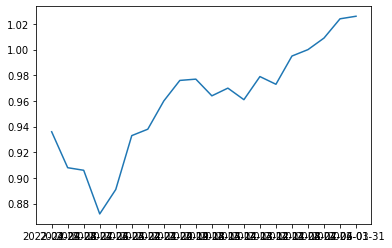

In [7]:
plt.plot(df['净值日期'],df['单位净值'])
plt.show()

---

---

# Selenium start from here


In [1]:
from selenium import webdriver
import re
import time
import pandas as pd
from matplotlib import pyplot as plt

edge_options = webdriver.EdgeOptions()
edge_options.add_argument('headless')   # 无窗口运行
# url = 'http://fundf10.eastmoney.com/jjjz_014673.html'
# url = 'http://fundf10.eastmoney.com/jjjz_000001.html'
browser = webdriver.Edge(options=edge_options)


In [2]:
def get_fund_list():
    '''
    获取基金列表，基金名称列表、基金代码列表、基金净值网址列表
    '''
    url = 'https://fund.eastmoney.com/data/fundranking.html#tgp'
    browser.get(url)
    browser.find_element_by_xpath('//*[@id="showall"]').click()
    time.sleep(4)
    data = browser.page_source
    table = pd.read_html(data)
    df = table[3]
    # print(df['基金  代码'])
    url_list = []
    code_list = []
    fund_name=df['基金简称']
    for i in range(len(df['基金  代码'])):
        x =str(df['基金  代码'][i]).zfill(6)
        code_list.append(x)
        url0 = 'http://fundf10.eastmoney.com/jjjz_{}.html'.format(x)
        url_list.append(url0)
    return url_list, fund_name, code_list
url_list, fund_name, code_list = get_fund_list()

C:\Users\Natlqs1234\AppData\Local\Temp\ipykernel_22792\3033605603.py:4: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  browser.find_element_by_xpath('//*[@id="showall"]').click()


In [ ]:
def get_one_fund(url, fund_name, code_list):
    '''
    爬取基金净值，并写入文件
    '''
    for i in range(len(url)):
        browser.get(url[i])
        data0 = browser.page_source
        title = browser.find_element_by_xpath('//*[@id="bodydiv"]/div[8]/div[3]/div[1]/div[1]/div[1]/h4/a').text
        print(title)
        a_list = re.findall('<label value=".*?">(.*?)</label>', data0)
        num = a_list[-2]
        df_list = []
        for j in range(0, int(num)):
            try:
                browser.find_element_by_xpath('//*[@id="pagebar"]/div[1]/label[8]').click() # or browser.find_element_by_xpath('//*[@id="pagebar"]/div[1]/label[8]').click()
                time.sleep(0.5)
                data = browser.page_source
                table = pd.read_html(data)
                df_list.append(table[3])
            except:
                pass
            try:
                browser.find_element_by_xpath('//*[@id="pagebar"]/div[1]/label[6]').click() 
                time.sleep(0.5)
                data = browser.page_source
                table = pd.read_html(data)
                df_list.append(table[3])
            except:
                pass
        df = pd.concat(df_list)
        df.to_csv('.\\funds\\{}{}.csv'.format(fund_name[i], code_list[i]), encoding='utf_8_sig', index=False)
    browser.quit()

get_one_fund(url_list[0:30], fund_name[0:30], code_list[0:30]) # 爬取前30个基金

---

---

# Requests starts from here

In [32]:
import requests
import json
import re
import pandas as pd

def get_fund_data(name, code, page = 8):
    df_list = []
    for index in range(1, page):
        url = 'http://api.fund.eastmoney.com/f10/lsjz?callback=jQuery183041965288156257285_1651553972295&fundCode={}&pageIndex={}&pageSize=20&startDate=&endDate=&_=1651553987192'.format(code, index)
        headers = {
            'Referer': 'http://fundf10.eastmoney.com/',# 防盗链，确定访问来源
            'User-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36 Edg/101.0.1210.32'
            }

        resp = requests.get(url, headers=headers)
        html = resp.text
        res = re.findall('\((.*?)\)', html)
        # print(res)
        datas = json.loads(res[0])['Data']['LSJZList']      # json
        df = pd.DataFrame(datas)
        df_list.append(df)
    df_datas = pd.concat(df_list)
    # print(df_datas)
    df_datas.to_csv('.\\funds\\{}{}.csv'.format(name, code), encoding='utf_8_sig', index=False)


def get_fund_ranking(num):

    headers = {
        'Referer': 'http://fundf10.eastmoney.com/data/fundranking.html',# 防盗链，确定访问来源
        'User-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.41 Safari/537.36 Edg/101.0.1210.32'
        }
    base_url = 'http://fund.eastmoney.com/data/rankhandler.aspx?op=ph&dt=kf&ft=gp&rs=&gs=0&sc=6yzf&st=desc&sd=2021-05-03&ed=2022-05-03&qdii=&tabSubtype=,,,,,&pi={}&pn=50&dx=1&v=0.2985985268119471'.format(num)
    response = requests.get(base_url, headers=headers)    
    # print(response.text)
    result = re.findall('"(.*?)"', response.text)
    # print(result)
    # print(len(result))
    for i in result:
        code = i.split(',')[0]
        name = i.split(',')[1]
        get_fund_data(name, code )


# get_fund_ranking(1)



## 可视化

### pyplot

In [ ]:
import matplotlib.pyplot as plt
import mplcyberpunk
import pandas as pd

df1 = pd.read_csv('.\\funds\\前海开源中药股票A005505.csv')
df2 = pd.read_csv('.\\funds\\建信沪深300红利ETF联接A012712.csv')

plt.style.use("cyberpunk")
plt.plot(df1['FSRQ'].tolist()[::-1], df1['DWJZ'].tolist()[::-1], marker = 'o')
plt.plot(df2['DWJZ'].tolist()[::-1], marker = 'o')
mplcyberpunk.add_glow_effects()
plt.show()


### pyecharts